In [2]:
import pickle

import pandas as pd
import numpy as np
import tqdm

from scipy.stats.stats import spearmanr
from scipy.stats.stats import kendalltau

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder

### Задание 1. Считывание и предобработка данных

In [3]:
with open('players.pkl', 'rb') as f:
    players = pickle.load(f)
    
with open('tournaments.pkl', 'rb') as f:
    tournaments = pickle.load(f)

with open('results.pkl', 'rb') as f:
    results = pickle.load(f)
    
df_players = pd.DataFrame(players.values()).set_index('id')

df_tournaments = pd.DataFrame(tournaments.values()).set_index('id', drop=True)

df_tournaments['t_id'] = df_tournaments.index
df_tournaments['dateStart'] = pd.to_datetime(df_tournaments['dateStart'], utc=True)
df_tournaments['dateEnd'] = pd.to_datetime(df_tournaments['dateEnd'], utc=True)

df_tournaments['start_year'] = pd.DatetimeIndex(df_tournaments['dateStart']).year
df_tournaments['start_month'] = pd.DatetimeIndex(df_tournaments['dateStart']).month

df_tournaments['type_id'] = [v['id'] for v in df_tournaments['type']]
df_tournaments['type_name'] = [v['name'] for v in df_tournaments['type']]

df_tournaments['q_qty'] = df_tournaments['questionQty'].apply(
                                            lambda qty: 0 if not qty else sum([v for k, v in qty.items()]))

df_tournaments.drop('synchData', inplace=True, axis=1)
df_tournaments.drop('orgcommittee', inplace=True, axis=1)
df_tournaments.drop('type', inplace=True, axis=1)

In [6]:
df_tournaments_train = df_tournaments[df_tournaments.start_year == 2019]
df_tournaments_test = df_tournaments[df_tournaments.start_year == 2020]

In [163]:
df_tournaments_train.sample(5)

,name,dateStart,dateEnd,season,questionQty,start_year,start_month,type_id,type_name,q_qty
id,,,,,,,,,,
5551,Дилижанские игры,2019-04-12 10:00:00+00:00,2019-04-14 11:00:00+00:00,/seasons/52,"{'1': 15, '2': 15, '3': 15, '4': 15, '5': 15}",2019,4,2,Обычный,75
5651,Первая октава: Прелюдия,2019-08-30 17:00:00+00:00,2019-09-03 17:00:00+00:00,/seasons/53,"{'1': 12, '2': 12, '3': 12}",2019,8,3,Синхрон,36
5526,U-Mind Games – взрослые,2019-03-09 05:00:00+00:00,2019-03-10 11:00:00+00:00,/seasons/52,"{'1': 12, '2': 12, '3': 12, '4': 12, '5': 12, ...",2019,3,2,Обычный,72
5206,Из Минска с любовью. Этап 6.,2019-04-20 16:00:00+00:00,2019-04-24 16:00:00+00:00,/seasons/52,"{'1': 18, '2': 18}",2019,4,3,Синхрон,36
5974,Янтарный лингам,2019-10-04 15:00:00+00:00,2020-02-23 15:00:00+00:00,/seasons/53,"{'1': 12, '2': 12, '3': 12}",2019,10,8,Асинхрон,36


In [252]:
df_tournaments_test.q_qty.describe()

count    416.000000
mean      43.593750
std       23.267763
min        3.000000
25%       36.000000
50%       36.000000
75%       45.000000
max      330.000000
Name: q_qty, dtype: float64

### Задание 2. Построение baseline-модели для обучения рейтинг-листа игроков

Преобразуем данные в повопросные резулультаты для каждого игрока. Вопросы разделим на 5 уровней сложности и просэмплировав результаты нескольких турниров посчитаем рейтинг-лист.

In [17]:
question_result = []

for t_id in tqdm.tqdm(df_tournaments_train.index):
    q_qty = df_tournaments.loc[t_id]['q_qty']

    if q_qty == 0:
        continue   
    
    q_correct = np.zeros(q_qty)
    q_canceled = np.zeros(q_qty)
    q_wrong = np.zeros(q_qty)
        
    for team in results[t_id]:
        if team.get('mask') is None:
            continue
            
        curr_correct = np.array([1 if x == '1' else 0 for x in team['mask']])
        curr_wrong = np.array([1 if (x != 'X') and (x != '1') else 0 for x in team['mask']])
        curr_canceled = np.array([1 if x == 'X' else 0 for x in team['mask']])
        
        answer_size = len(team['mask'])
        answer_size = answer_size if q_qty > answer_size else q_qty

        q_correct[:answer_size] += curr_correct[:answer_size]           
        q_wrong[:answer_size] += curr_wrong[:answer_size]           
        q_canceled[:answer_size] += curr_canceled[:answer_size]                  
            
    for i, res in enumerate(zip(q_correct, q_wrong, q_canceled)):
        if res[0] + res[1] <= 0:
            continue
        
        question_result.append({'idx': f'{t_id}_{i + 1}', 't_id': t_id, 'q_id': f'{i + 1}', 
                                'correct': res[0], 'wrong': res[1], 'canceled': res[2],
                                'difficulty': 1 - res[0] / (res[0] + res[1])})

100%|██████████| 689/689 [00:02<00:00, 264.92it/s]


In [18]:
#Оставим только те вопросы, которые не были отменены  
df_questions = pd.DataFrame(question_result)
canceled_questions = df_questions[df_questions.canceled != 0]['idx'].values
df_questions = df_questions[df_questions.canceled == 0]
df_questions.drop('canceled', inplace=True, axis=1)
df_questions.tail(5)

,idx,t_id,q_id,correct,wrong,difficulty
33367,6255_212,6255,212,119.0,233.0,0.661932
33368,6255_213,6255,213,238.0,114.0,0.323864
33369,6255_214,6255,214,201.0,151.0,0.428977
33370,6255_215,6255,215,32.0,320.0,0.909091
33371,6255_216,6255,216,46.0,306.0,0.869318


In [19]:
canceled_questions

array(['6085_3', '6085_48', '6085_93', '6255_2', '6255_38', '6255_74',
       '6255_110', '6255_146'], dtype=object)

In [22]:
df_questions['d_rank'] = pd.cut(df_questions.difficulty, bins=quntile.values, labels=[1, 2, 3, 4, 5])

In [23]:
df_questions

,idx,t_id,q_id,correct,wrong,difficulty,d_rank
0,4772_1,4772,1,204.0,27.0,0.116883,1
1,4772_2,4772,2,180.0,51.0,0.220779,1
2,4772_3,4772,3,103.0,128.0,0.554113,3
3,4772_4,4772,4,120.0,111.0,0.480519,2
4,4772_5,4772,5,203.0,28.0,0.121212,1
...,...,...,...,...,...,...,...
33367,6255_212,6255,212,119.0,233.0,0.661932,3
33368,6255_213,6255,213,238.0,114.0,0.323864,2
33369,6255_214,6255,214,201.0,151.0,0.428977,2
33370,6255_215,6255,215,32.0,320.0,0.909091,5


In [25]:
players_result = []

for t_id in tqdm.tqdm(df_tournaments_train.index):
# for t_id in tqdm.tqdm(df_tournaments_train.loc[[6085]].index):

    q_qty = df_tournaments.loc[t_id]['q_qty']
    
    if q_qty == 0:
        continue   
            
    for team in results[t_id]:
        if team.get('mask') is None:
            continue
                
        answer_size = len(team['mask'])
        answer_size = answer_size if q_qty > answer_size else q_qty
            
        for i, res in enumerate(team['mask'][:answer_size]):
            if f'{t_id}_{i + 1}' in canceled_questions:
                continue

            for member in team['teamMembers']:
                players_result.append({'m_id': member['player']['id'], 'q_id': f'{t_id}_{i + 1}',
                                       'answered': 1 if res == '1' else 0 , 'failed': 0 if res == '1' else 1})
                
df_players_result = pd.DataFrame(players_result)
df_players_result.head(5)

100%|██████████| 689/689 [00:43<00:00, 15.87it/s]


,m_id,q_id,answered,failed
0,6212,4772_1,1,0
1,18332,4772_1,1,0
2,18036,4772_1,1,0
3,22799,4772_1,1,0
4,15456,4772_1,1,0


In [26]:
df_players_result.shape

(21068129, 4)

In [27]:
df_players_result_extended = df_players_result.merge(df_questions, how='left', left_on='q_id', right_on='idx')

In [30]:
df_players_result_extended

,m_id,q_id_x,answered,failed,idx,t_id,q_id_y,correct,wrong,difficulty,d_rank
0,6212,4772_1,1,0,4772_1,4772.0,1,204.0,27.0,0.116883,1
1,18332,4772_1,1,0,4772_1,4772.0,1,204.0,27.0,0.116883,1
2,18036,4772_1,1,0,4772_1,4772.0,1,204.0,27.0,0.116883,1
3,22799,4772_1,1,0,4772_1,4772.0,1,204.0,27.0,0.116883,1
4,15456,4772_1,1,0,4772_1,4772.0,1,204.0,27.0,0.116883,1
...,...,...,...,...,...,...,...,...,...,...,...
21068124,217156,6255_35,0,1,6255_35,6255.0,35,421.0,1598.0,0.791481,4
21068125,217153,6255_36,0,1,6255_36,6255.0,36,1345.0,674.0,0.333829,2
21068126,217154,6255_36,0,1,6255_36,6255.0,36,1345.0,674.0,0.333829,2
21068127,217155,6255_36,0,1,6255_36,6255.0,36,1345.0,674.0,0.333829,2


Строим для каждого игрока статистику по проценту и количеству взятых вопросов каждой категории

In [31]:
df_stats = df_players_result_extended.groupby(['m_id', 'd_rank']).agg({'answered':'sum', 'failed':'sum'})
df_stats['p_correct'] = df_stats['answered'] / (df_stats['answered'] + df_stats['failed'])
df_stats['n_count'] = df_stats['answered'] + df_stats['failed']
df_stats = df_stats[['n_count', 'p_correct']].unstack()

df_stats['n_count'] = df_stats['n_count'].fillna(0)
df_stats['p_correct'] = df_stats['p_correct'].fillna(df_stats['p_correct'].median())

df_stats.columns = ['%s%s' % (a, '_%s' % b if b else '') for a, b in df_stats.columns]

for i in range(1, 6):
    min_n = df_stats[f'n_count_{i}'].min(axis=0)
    max_n = df_stats[f'n_count_{i}'].max(axis=0)
    
    median_p = df_stats[f'p_correct_{i}'].quantile(.88)
    median_n = df_stats[f'n_count_{i}'].median(axis=0)
    
    df_stats.loc[(df_stats[f'p_correct_{i}'] > median_p) & (df_stats[f'n_count_{i}'] < median_n), f'p_correct_{i}'] = df_stats[f'p_correct_{i}'].median(axis=0)

    if i < 2:
        df_stats.loc[(df_stats[f'p_correct_{i}'] > 0.977), f'p_correct_{i}'] = df_stats[f'p_correct_{i}'].median(axis=0)
    else:
        df_stats.loc[df_stats[f'n_count_{i}'] < 5 , f'p_correct_{i}'] = df_stats[f'p_correct_{i}'].median(axis=0)
        df_stats.loc[(df_stats[f'p_correct_{i}'] > 0.977), f'p_correct_{i}'] = df_stats[f'p_correct_{i}'].median(axis=0)        
    df_stats[f'n_count_{i}'] = (df_stats[f'n_count_{i}'] - min_n) / (max_n - min_n)

In [42]:
df_players_result_vs_df = df_players_result_extended.drop(['failed', 'q_id_x', 't_id',
                                                        'q_id_y', 'correct', 'wrong', 'd_rank', 'idЬx' ], axis=1).dropna()

df_final = df_players_result_vs_df.merge(df_stats, how='left', left_on='m_id', right_on='m_id')
df_final = df_final.sort_values(by=['m_id'])

Получаем финальную таблицу для расчета рейтинга - к статистике игрока добавлена сложность вопроса

In [164]:
df_final.head()

,m_id,answered,difficulty,n_count_1,n_count_2,n_count_3,n_count_4,n_count_5,p_correct_1,p_correct_2,p_correct_3,p_correct_4,p_correct_5,pred,q_qty
10481087,15,0,0.672897,0.061187,0.063996,0.071604,0.061942,0.040757,0.717172,0.460432,0.30137,0.161017,0.053571,0,1
10480985,15,1,0.401869,0.061187,0.063996,0.071604,0.061942,0.040757,0.717172,0.460432,0.30137,0.161017,0.053571,1,1
10480979,15,0,0.514019,0.061187,0.063996,0.071604,0.061942,0.040757,0.717172,0.460432,0.30137,0.161017,0.053571,0,1
10480973,15,0,0.859813,0.061187,0.063996,0.071604,0.061942,0.040757,0.717172,0.460432,0.30137,0.161017,0.053571,0,1
10480967,15,0,0.598131,0.061187,0.063996,0.071604,0.061942,0.040757,0.717172,0.460432,0.30137,0.161017,0.053571,0,1


In [48]:
y_train = df_final['answered']
X_train = df_final.drop(['m_id', 'answered'], axis=1).to_numpy()

In [49]:
model = LogisticRegression()
model.fit(X_train, y_train)
pred = model.predict(X_train)
print(f'Accuracy: {np.sum(pred == y_train) / len(y_train)}')

D:\Continuum\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy: 0.7515666973410126


In [50]:
df_final['pred'] = pred
df_final['q_qty'] = 1

Для составления рейтинга сэмплируем вопросы из выборки и считаем количество правильных ответов

In [57]:
df_question_sample = df_questions.sample(15000).copy()['difficulty']
df_players_q_total = df_final.groupby(['m_id']).agg({'q_qty':'sum'})
rating = []
for m_id in tqdm.tqdm(df_players_q_total.index):
    df_final_sample = df_stats.loc[m_id]
    sample_data = np.hstack([df_question_sample.to_numpy().reshape(-1,1), np.tile(df_final_sample.to_numpy(),(15000,1))])
    pred_rating = model.predict(sample_data).sum()
    rating.append({'id':m_id, 'rating':pred_rating})

100%|██████████| 59271/59271 [02:03<00:00, 479.79it/s]


Распределение сложности вопросов в сэмпле

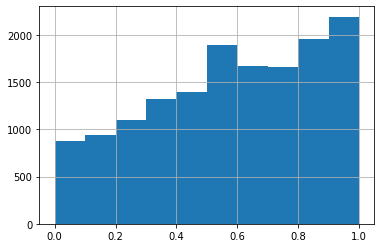

In [165]:
df_question_sample.hist()

Распределение рассчитанного рейтинга игроков

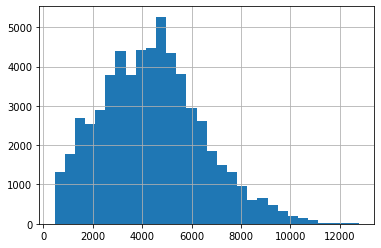

In [60]:
players_rating.rating.hist(bins=30)

In [ ]:
players_names = pd.DataFrame([v for k, v in players.items()])
players_names.index = players_names.id
players_names.drop('id', axis=1, inplace=True)

players_rating.index = players_rating.id
players_rating.drop('id', axis=1, inplace=True)

players_rating = pd.merge(players_rating, players_names, how='left', left_index=True, right_index=True)

Топ-20 лист-рейтинга расчитанного моделью

In [167]:
players_rating.head(20)

,rating,name,patronymic,surname
id,,,,
4270,12773,Александра,Владимировна,Брутер
28751,12684,Иван,Николаевич,Семушин
197536,12525,Елизавета,Алексеевна,Рахманова
197538,12525,Анастасия,Евгеньевна,Васильева
197539,12525,Никита,Станиславович,Бабич
197535,12525,Тимофей,Геннадиевич,Дедов
197537,12525,Константин,Романович,Фонов
197534,12525,Полина,Сергеевна,Колычева
27822,12343,Михаил,Владимирович,Савченков


### Задание 3. Оценка качества предсказаний результато турниров

Оценим рейтинг команды по рейтингу входящих в неё игроков для турниров из выборки test

In [68]:
team_results = []
spearman_corr = []
kendall_corr = []

for t_id in df_tournaments_test.index:  
    predicted_pos = []
    real_pos = []

    for team in results[t_id]:
        if team.get('teamMembers') is None or team.get('position') is None:
            continue

        real_res = team['position']               
        predicted_res = 0        
        
        team_size = len(team['teamMembers'])
        for member in team['teamMembers']:           
            if member['player']['id'] not in players_rating.index:
                team_size -= 1
            else:
                predicted_res += players_rating.loc[member['player']['id']].rating
      
        if team_size > 0:
            team_results.append({'t_id': t_id, 'real_rating': real_res, 'pred': predicted_res})
            real_pos.append(-real_res)
            predicted_pos.append(predicted_res / len(team['teamMembers']))
    s_corr = spearmanr(real_pos, predicted_pos)[0]
    k_corr = kendalltau(real_pos, predicted_pos)[0]
    
    if np.isnan(s_corr) or np.isnan(k_corr):
        continue
    
    spearman_corr.append(s_corr)
    kendall_corr.append(k_corr)

D:\Continuum\lib\site-packages\numpy\lib\function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
D:\Continuum\lib\site-packages\numpy\lib\function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
D:\Continuum\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
D:\Continuum\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
D:\Continuum\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [69]:
print(f'Корреляция Спирмена: {np.mean(spearman_corr)}')
print(f'Корреляция Кендалла: {np.mean(kendall_corr)}')

Корреляция Спирмена: 0.7095099953752463
Корреляция Кендалла: 0.5549987284602221


Корреляции попали в ожидаемые интервалы

### Задание 4. EM-алгоритм

Для простроения EM-модели забудем всё, что мы делали, и обучим новую модель, которая будет предсказывать ответил ли игрок (m_id) на вопрос (q_id) используя OHE. Для оценки качества будем предполагать, что команда ответила на вопрос если хотя бы один человек из команды ответил на него.

In [138]:
A = encoder.transform(df_players_result[["m_id", "q_id"]][:10])
A.toarray().shape

(10, 92716)

In [137]:
encoder = OneHotEncoder()
encoder.fit(df_players_result[["m_id", "q_id"]])
X_train = encoder.transform(df_players_result[["m_id", "q_id"]])
y_train = df_players_result['answered']

D:\Continuum\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [153]:
%%time

model_base = LogisticRegression(verbose=1, solver='saga')
model_base.fit(X_train, y_train)
pred = model.predict(X_train)
print(f'Accuracy: {np.sum(pred == y_train)/len(pred)}')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 25 epochs took 412 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.9min finished


Accuracy: 0.7635366671620437
Wall time: 6min 53s


In [154]:
print(f'Accuracy: {np.sum(pred2 == y_train)/len(pred)}')

Accuracy: 0.7635367146271034


In [155]:
team_results = []
spearman_corr = []
kendall_corr = []

for t_id in df_tournaments_test.index:  
    predicted_pos = []
    real_pos = []

    for team in results[t_id]:
        if team.get('teamMembers') is None or team.get('position') is None:
            continue
        real_res = team['position']               
        predicted_res = 0        
        
        team_size = len(team['teamMembers'])
        cur_team = []
        for member in team['teamMembers']:           
            if member['player']['id'] not in players_rating.index:
                team_size -= 1
            else:
                cur_team.append({'m_id': member['player']['id'], 'q_id': f'{t_id}_1'})
        if team_size > 0:            
            X_team = encoder.transform(pd.DataFrame(cur_team))
            team_predict = model_base.predict_proba(X_team)[:, 1]
            predicted_res = 1 - np.prod(1 - team_predict)
            team_results.append({'t_id': t_id, 'real_rating': real_res, 'pred': predicted_res})
            real_pos.append(-real_res)
            predicted_pos.append(predicted_res)
                  
    s_corr = spearmanr(real_pos, predicted_pos)[0]
    k_corr = kendalltau(real_pos, predicted_pos)[0]
    
    if np.isnan(s_corr) or np.isnan(k_corr):
        continue
    
    spearman_corr.append(s_corr)
    kendall_corr.append(k_corr)

D:\Continuum\lib\site-packages\numpy\lib\function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
D:\Continuum\lib\site-packages\numpy\lib\function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
D:\Continuum\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
D:\Continuum\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
D:\Continuum\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
D:\Continuum\lib\site-packages\numpy\lib\function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
D:\Continuum\lib\site-packages\numpy\lib\function_base.py:2531: RuntimeWarning: invalid value encountered i

In [156]:
print(f'Корреляция Спирмена: {np.mean(spearman_corr)}')
print(f'Корреляция Кендалла: {np.mean(kendall_corr)}')

Корреляция Спирмена: 0.8065093363200029
Корреляция Кендалла: 0.6489561643700283


Результаты получились лучше, чем baseline с рассчитанной сложностью вопросов, а самое обидное, что не только лучше, но и намного быстрее.

К сожалению, EM-алгоритм довести до ума не получилось

### Задание 5. А что с вопросами?

Воспользуемся знаниями, полученными на шаге 2 (ура, всё было не зря!). Рейтинг лист пакетов получился

In [222]:
df_tournaments_rating = df_questions.groupby(['t_id']).agg({'difficulty':'sum', 'correct':'sum', 'wrong':'sum' })
df_top = df_tournaments_rating.merge(df_tournaments, how='left', left_on='t_id', right_on='t_id').sort_values(by=['difficulty'], ascending=False)
df_top[['t_id', 'name', 'difficulty']].head(5)

,t_id,name,difficulty
637,6090,Дзержинский марафон,215.600000
469,5827,Шестой киевский марафон. Асинхрон,185.250000
665,6149,Чемпионат Санкт-Петербурга. Первая лига,180.000000
123,5405,Кавалькада волхвов,179.800000
632,6085,Серия Гран-при. Общий зачёт,162.949097


In [223]:
df_tournaments_rating = df_questions.groupby(['t_id']).agg({'difficulty':'sum', 'correct':'sum', 'wrong':'sum' })  
df_top = df_tournaments_rating.merge(df_tournaments, how='left', left_on='t_id', right_on='t_id').sort_values(by=['difficulty'], ascending=False)
df_top[['t_id', 'name', 'difficulty']].tail(5)

,t_id,name,difficulty
398,5726,Первый турнир имени Джоуи Триббиани,11.387097
547,5935,Асинхрон по «Королю и Шуту»,10.552632
570,5963,Асинхрон по South Park,9.333333
600,6003,Второй тематический турнир имени Джоуи Триббиани,9.148148
154,5438,Синхрон Лиги Разума,6.789474
